<a href="https://colab.research.google.com/github/juooo1117/ROADs/blob/main/obstacle_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My\ Drive/FinalProject/

/content/drive/My Drive/FinalProject


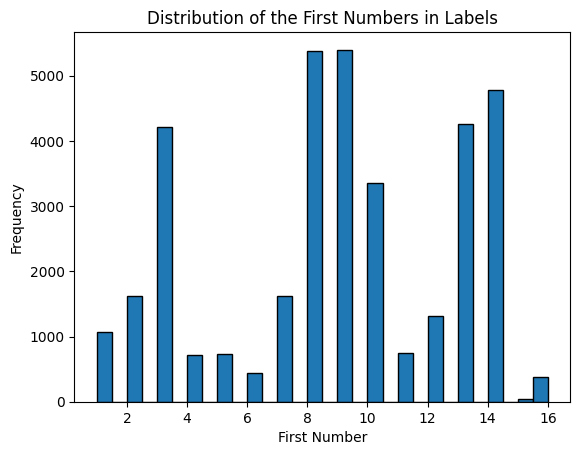

In [6]:
import os
import matplotlib.pyplot as plt

labels_paths = ['/content/drive/MyDrive/FinalProject/train/labels',
                '/content/drive/MyDrive/FinalProject/valid/labels']

# Initialize an empty list to store first numbers from all files
first_numbers = []

# Iterate over each labels path
for labels_path in labels_paths:
    # Get all .txt files in the current labels path
    label_files = [f for f in os.listdir(labels_path) if f.endswith('.txt')]

    # Iterate over each .txt file
    for label_file in label_files:
        label_file_path = os.path.join(labels_path, label_file)

        # Read each line of the current .txt file and get the first number
        with open(label_file_path, 'r') as file:
            for line in file:
                first_number = int(line.split()[0])
                first_numbers.append(first_number)

# Plot histogram
plt.hist(first_numbers, bins=30, edgecolor='black')
plt.title('Distribution of the First Numbers in Labels')
plt.xlabel('First Number')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#        "names" : {0 : 'etc', 1 : 'PE드럼 정상', 2 : 'PE드럼 파손', 3 : 'PE방호벽 정상', 4 : 'PE방호벽 파손',
#                   5 : 'PE안내봉 정상', 6 : 'PE안내봉 파손', 7 : '라바콘 정상', 8 : '라바콘 파손',
#                   9 : '시선유도봉 정상', 10 : '시선유도봉 파손', 11 : '제설함 정상', 12 : '제설함 파손',
#                   13 : 'PE입간판 정상', 14 : 'PE입간판 파손', 15 : 'PE휀스 정상', 16 : 'PE휀스 파손'}
#        }

# YOLOv8n model load

In [ ]:
!pip install ultralytics

In [ ]:
import cv2

from ultralytics import YOLO
import os
from IPython.display import Image, display
from IPython import display
display.clear_output()
!yolo mode=checks

#model = YOLO("yolov8n.pt")

# Real-time detecting using webcam

In [ ]:
# webcam 연결
cap = cv2.VideoCapture(0)

while cap.isOpened():
    success, image = cap.read()     # 1개 frame을 image로 읽는다.
    if not success:
        print("Ignoring empty camera frame.")
        # If loading a video, use 'break' instead of 'continue'.
        break

    # To improve performance
    frame = cv2.flip(image, 1)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # inference result
    result = model(img,
                   conf = 0.5,        # 'inference prob > 0.5'인 것만 결과로 return
                   verbose = False)   # 추론 결과 로그를 출력하지 않음

    # 결과에서 위치, 클래스 정보 추출
    xyxy_list = result.boxes.xyxy.to('cpu').numpy().astype('int32')
    cls_list = result.boxes.cls.to('cpu').numpy().astype('int32')
    conf_list = result.boxes.conf.to('cpu').numpy()

    # for in 문을 이용해 찾은 object 별로 bbox 처리를 한다.
    for xyxy, cls, conf in zip(xyxy_list, cls_list, conf_list):
        pt1, pt2 = xyxy[:2], xyxy[2:]
        txt = f'{result.names[cls]} - {conf*100:.3f}%'
        # box
        cv2.rectangle(frame, pt1, pt2, color=(255,0,0), thickness=2)
        cv2.putText(frame, txt, org=pt1, fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=0.5,
                    color=(200,0,0), thickness=1, lineType=cv2.LINE_AA)

    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()             # 웹캠연결 종료
cv2.destroyAllWindows()   # 출력 윈도우 종료

# Dataset pre-processing for YOLO Model

### json to txt

In [ ]:
import glob
import json
import pandas as pd

json_file_path = '/content/drive/MyDrive/FinalProject/dataset/real_sunny_AM_20220614_112456_sedan_Dong-gu_00026.json'
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)

In [ ]:
# 'images'에서 'width', 'height', 'file_name' 추출
image_data = [{'width': img['width'],
               'height': img['height'],
               'file_name': img['file_name']} for img in data['images']]

# 'annotations'에서 'category_id', 'bbox' 추출
annotation_data = [{'category_id': ann['category_id'],
                    'bbox': ann['bbox']} for ann in data['annotations']]

df_images = pd.DataFrame(image_data)
df_annotations = pd.DataFrame(annotation_data)

df_images

width  height                                          file_name
0   1920    1080  real_sunny_AM_20220614_112456_sedan_Dong-gu_00...

In [ ]:
df_annotations

category_id                              bbox
0            9   [545.07, 216.31, 56.87, 208.71]
1            9  [167.11, 382.08, 132.67, 411.91]
2            9   [669.23, 156.16, 37.19, 149.74]
3            9   [409.57, 274.31, 78.65, 282.04]
4           12    [153.92, 185.8, 288.22, 139.0]

In [ ]:
# bbox 좌표: 좌상단 x, 좌상단 y, bbox의 W, box의 H
def convert_to_yolov8_format(bbox, image_width, image_height):
    x_center = (bbox[0] + bbox[2] / 2) / image_width
    y_center = (bbox[1] + bbox[3] / 2) / image_height
    width = bbox[2] / image_width
    height = bbox[3] / image_height

    return x_center, y_center, width, height

In [ ]:
##### 사용안함 #####
# image resizing을 위해서 써야하는 함수
def convert_to_yolov8_format(bbox, image_width, image_height, target_width, target_height):
    x_center = (bbox[0] + bbox[2] / 2) / image_width
    y_center = (bbox[1] + bbox[3] / 2) / image_height
    width = bbox[2] / image_width
    height = bbox[3] / image_height

    x_center *= target_width
    y_center *= target_height
    width *= target_width
    height *= target_height

    return x_center, y_center, width, height

In [ ]:
import os
import json

dataset_dir = '/content/drive/MyDrive/FinalProject'
dst_dir = '/content/drive/MyDrive/FinalProject/dataset'

# Iterate through all JSON files in the dataset directory
for json_file in os.listdir(dataset_dir):
    if json_file.endswith('.json'):
        json_path = os.path.join(dataset_dir, json_file)
        print(len(json_path))      # print

        with open(json_path, 'r') as f:
            data = json.load(f)

        # Process each annotation in the JSON file
        for annotation in data.get('annotations', []):
            label_path = os.path.join(dst_dir, "labels")

            if not os.path.exists(label_path):
                os.makedirs(label_path)

            image_name = data['images'][0]['file_name'].split('.')[0]
            print(f'image_name: {image_name}')

            image_width = data['images'][0]['width']
            image_height = data['images'][0]['height']
            print(f'image_width: {image_width}, image_height: {image_height}')

            label = annotation.get('category_id', None)
            bbox = annotation.get('bbox', None)
            print(f'label: {label}, bbox: {bbox}')

            if label is not None and bbox is not None:
                x_center, y_center, width, height = convert_to_yolov8_format(bbox=bbox,
                                                                             image_width=image_width,
                                                                             image_height=image_height)

                x_center = format(x_center, '.6f')
                y_center = format(y_center, '.6f')
                width = format(width, '.6f')
                height = format(height, '.6f')

                arr = list(map(str, [label, x_center, y_center, width, height]))
                data_line = ' '.join(arr) + '\n'

                # Save the data to a text file
                txt_filename = os.path.join(label_path, f"{image_name}.txt")
                with open(txt_filename, 'a', encoding='UTF-8') as txt_file:
                    txt_file.write(data_line)

90
image_name: real_sunny_PM_20220721_120348_sedan_Dong-gu_03034
image_width: 1920, image_height: 1080
label: 3, bbox: [1259.74, 70.31, 43.16, 58.69]
image_name: real_sunny_PM_20220721_120348_sedan_Dong-gu_03034
image_width: 1920, image_height: 1080
label: 3, bbox: [1469.48, 95.48, 72.93, 91.19]
image_name: real_sunny_PM_20220721_120348_sedan_Dong-gu_03034
image_width: 1920, image_height: 1080
label: 7, bbox: [1757.06, 209.43, 95.85, 129.11]


In [ ]:
labels_path = '/content/drive/MyDrive/FinalProject/dataset/labeling'

txt_files = [f for f in os.listdir(labels_path) if f.endswith('.txt')]
print("Number of .txt files in the directory:", len(txt_files))

Number of .txt files in the directory: 19999


In [ ]:
# (label, x_center, y_center, w, h) 순서로 데이터가 들어가 있는 것 확인!
eg = '/content/drive/MyDrive/FinalProject/dataset/labels/real_sunny_PM_20220721_120348_sedan_Dong-gu_03034.txt'

with open(eg, 'r', encoding='UTF-8') as file:
    content = file.read()
print(content)

3 0.667354 0.092273 0.022479 0.054343
3 0.784346 0.130625 0.037984 0.084435
7 0.940096 0.253690 0.049922 0.119546



# Train YOLOv8n Object Detection on a Custom Dataset

In [5]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## dataset 옮기기

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# yolo .yaml 파일 형식에 맞추기 위해서 .txt & .jpg 이동
image_source_path = '/content/drive/MyDrive/FinalProject/dataset/img'
label_source_path = '/content/drive/MyDrive/FinalProject/dataset/labeling'

split_ratio = 0.8

train_image_dest_path = '/content/drive/MyDrive/FinalProject/train/images'
train_label_dest_path = '/content/drive/MyDrive/FinalProject/train/labels'
valid_image_dest_path = '/content/drive/MyDrive/FinalProject/valid/images'
valid_label_dest_path = '/content/drive/MyDrive/FinalProject/valid/labels'

# original files list
image_files = [f for f in os.listdir(image_source_path) if f.endswith('.jpg')]
train_images, valid_images = train_test_split(image_files,
                                              test_size=1-split_ratio,
                                              random_state=1117)

# move to train directory
for image_file in train_images:
    label_file = image_file.replace('.jpg', '.txt')

    # check the file name between .jpg and .txt
    if os.path.exists(os.path.join(label_source_path, label_file)):
        shutil.move(os.path.join(image_source_path, image_file), os.path.join(train_image_dest_path, image_file))
        shutil.move(os.path.join(label_source_path, label_file), os.path.join(train_label_dest_path, label_file))
        print(f"move to train: {image_file}, {label_file}")

# move to valid directory
for image_file in valid_images:
    label_file = image_file.replace('.jpg', '.txt')

    # check the file name between .jpg and .txt
    if os.path.exists(os.path.join(label_source_path, label_file)):
        shutil.move(os.path.join(image_source_path, image_file), os.path.join(valid_image_dest_path, image_file))
        shutil.move(os.path.join(label_source_path, label_file), os.path.join(valid_label_dest_path, label_file))
        print(f"move to valid: {image_file}, {label_file}")

print("ALL DONE")

In [ ]:
train_image_pth = '/content/drive/MyDrive/FinalProject/train/images'
train_label_pth = '/content/drive/MyDrive/FinalProject/train/labels'
valid_image_pth = '/content/drive/MyDrive/FinalProject/valid/images'
valid_label_pth = '/content/drive/MyDrive/FinalProject/valid/labels'
dataset_img_path = '/content/drive/MyDrive/FinalProject/dataset/img'
dataset_labeling_path = '/content/drive/MyDrive/FinalProject/dataset/labeling'

train_image_files = [f for f in os.listdir(train_image_pth) if f.endswith('.jpg')]
train_label_files = [f for f in os.listdir(train_label_pth) if f.endswith('.txt')]
valid_image_files = [f for f in os.listdir(valid_image_pth) if f.endswith('.jpg')]
valid_label_files = [f for f in os.listdir(valid_label_pth) if f.endswith('.txt')]
dataset_image_files = [f for f in os.listdir(dataset_img_path) if f.endswith('.jpg')]
dataset_label_files = [f for f in os.listdir(dataset_labeling_path) if f.endswith('.txt')]

print(f'Number of files in the TRAIN directory: image {len(train_image_files)}개, label {len(train_label_files)}개')
print(f'Number of files in the VALID directory: image {len(valid_image_files)}개, label {len(valid_label_files)}개')
print(f'Number of files in the DATASET directory: image {len(dataset_image_files)}개, label {len(dataset_label_files)}개')

Number of files in the TRAIN directory: image 16000개, label 16000개
Number of files in the VALID directory: image 4000개, label 4000개
Number of files in the DATASET directory: image 0개, label 0개


In [ ]:
# 동일한 이름의 파일이 train/valid 폴더로 나누어졌는지 확인!
dataset_img_path = '/content/drive/MyDrive/FinalProject/valid/images'
dataset_labeling_path = '/content/drive/MyDrive/FinalProject/valid/labels'

img_files = {f[:-4] for f in os.listdir(dataset_img_path) if f.endswith('.jpg')}
labeling_files = {f[:-4] for f in os.listdir(dataset_labeling_path) if f.endswith('.txt')}

matching_files_count = len(img_files.intersection(labeling_files))

print(f"두 경로에 동일한 파일 이름이 {matching_files_count}개 있습니다.")

두 경로에 동일한 파일 이름이 4000개 있습니다.


In [ ]:
# 동일하지 않은 파일 이름은 무엇인지 확인!
img_files = {f[:-4] for f in os.listdir(dataset_img_path) if f.endswith('.jpg')}
labeling_files = {f[:-4] for f in os.listdir(dataset_labeling_path) if f.endswith('.txt')}

non_matching_files_img = img_files - labeling_files
non_matching_files_labeling = labeling_files - img_files

print("일치하지 않는 이미지 파일 이름:")
for filename in non_matching_files_img:
    print(f"{filename}.jpg")

print("\n일치하지 않는 레이블 파일 이름:")
for filename in non_matching_files_labeling:
    print(f"{filename}.txt")

일치하지 않는 이미지 파일 이름:

일치하지 않는 레이블 파일 이름:


In [ ]:
import os, shutil

# 만약에 파일을 이동해야 한다면?
def move_files(source_folder, destination_folder):
    file_list = os.listdir(source_folder)

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    for filename in file_list:
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, filename)
        shutil.move(source_path, destination_path)
        print(f"{filename}을(를) {destination_folder}로 이동했습니다.")

move_files('/content/drive/MyDrive/FinalProject/train/images', '/content/drive/MyDrive/FinalProject/dataset/img')
move_files('/content/drive/MyDrive/FinalProject/valid/images', '/content/drive/MyDrive/FinalProject/dataset/img')

move_files('/content/drive/MyDrive/FinalProject/train/labels', '/content/drive/MyDrive/FinalProject/dataset/labeling')
move_files('/content/drive/MyDrive/FinalProject/valid/labels', '/content/drive/MyDrive/FinalProject/dataset/labeling')

In [ ]:
import yaml

# write yaml file with python
data = {"train" : '/content/drive/MyDrive/FinalProject/train/',
        "val" : '/content/drive/MyDrive/FinalProject/valid/',
        "names" : {0 : 'etc', 1 : 'PE드럼 정상', 2 : 'PE드럼 파손', 3 : 'PE방호벽 정상', 4 : 'PE방호벽 파손',
                   5 : 'PE안내봉 정상', 6 : 'PE안내봉 파손', 7 : '라바콘 정상', 8 : '라바콘 파손',
                   9 : '시선유도봉 정상', 10 : '시선유도봉 파손', 11 : '제설함 정상', 12 : '제설함 파손',
                   13 : 'PE입간판 정상', 14 : 'PE입간판 파손', 15 : 'PE휀스 정상', 16 : 'PE휀스 파손'}
        }

with open('/content/drive/MyDrive/FinalProject/data.yaml', 'w', encoding = 'UTF-8') as f :
  yaml.dump(data, f, allow_unicode=True)

# check written file
with open('/content/drive/MyDrive/FinalProject/data.yaml', 'r', encoding = 'UTF-8') as f :
    lines = yaml.safe_load(f)
    print(lines)

{'names': {0: 'etc', 1: 'PE드럼 정상', 2: 'PE드럼 파손', 3: 'PE방호벽 정상', 4: 'PE방호벽 파손', 5: 'PE안내봉 정상', 6: 'PE안내봉 파손', 7: '라바콘 정상', 8: '라바콘 파손', 9: '시선유도봉 정상', 10: '시선유도봉 파손', 11: '제설함 정상', 12: '제설함 파손', 13: 'PE입간판 정상', 14: 'PE입간판 파손', 15: 'PE휀스 정상', 16: 'PE휀스 파손'}, 'train': '/content/drive/MyDrive/FinalProject/train/', 'val': '/content/drive/MyDrive/FinalProject/valid/'}


이미지 파일이 존재합니다: /content/drive/MyDrive/FinalProject/train/images/real_sunny_AM_20220810_114306_sedan_Gijang-gun_00336.jpg


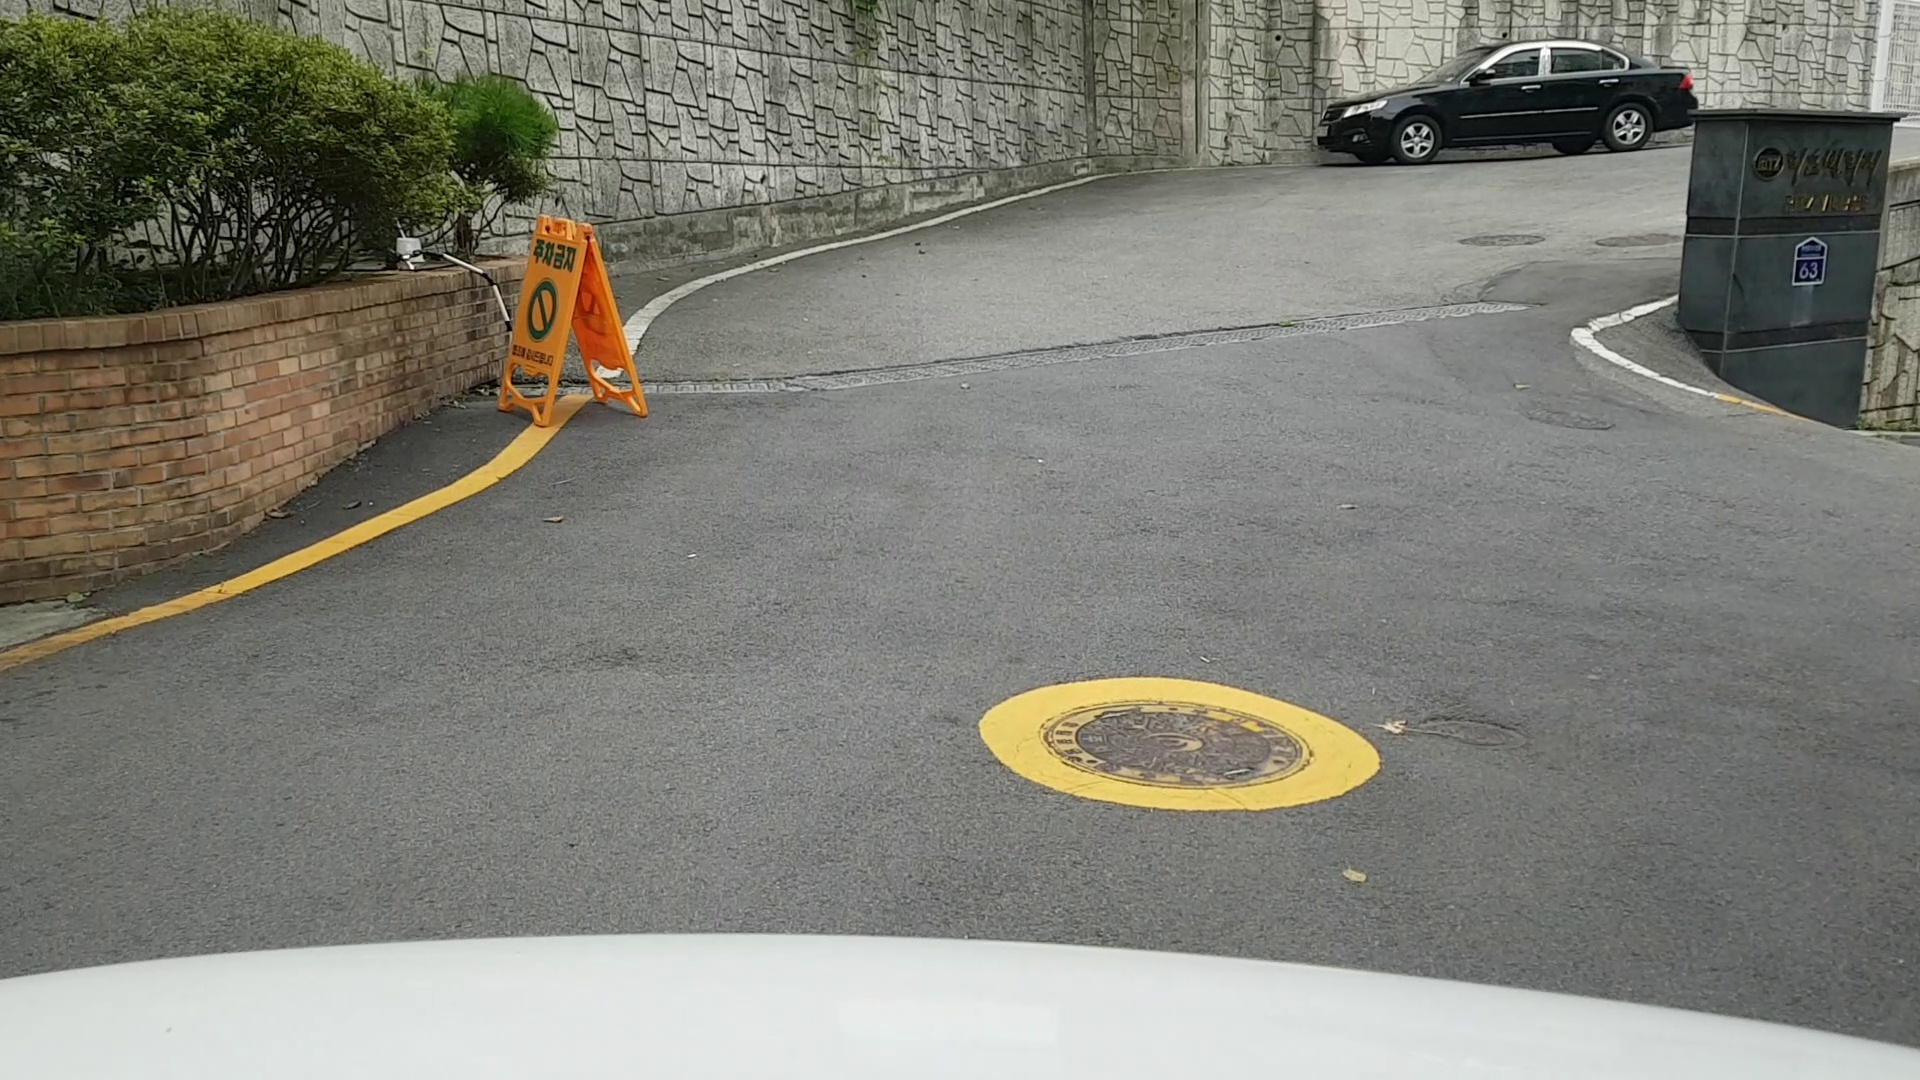

In [ ]:
# 파일이 실제로 해당 경로에 존재하는지 확인해보자
from IPython.display import Image, display
image_path = '/content/drive/MyDrive/FinalProject/train/images/real_sunny_AM_20220810_114306_sedan_Gijang-gun_00336.jpg'

if os.path.isfile(image_path):
    print(f"이미지 파일이 존재합니다: {image_path}")
    display(Image(filename=image_path, width=600))
else:
    print(f"이미지 파일이 존재하지 않습니다: {image_path}")

# Training

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data=/content/drive/MyDrive/FinalProject/data.yaml epochs=20 imgsz=[1920,1080] rect=True

Ultralytics YOLOv8.1.1 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/FinalProject/data.yaml, epochs=20, time=None, patience=50, batch=16, imgsz=[1920, 1080], save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=True, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

In [ ]:
# 이어서 학습하기 위한 코드
model = YOLO("/content/drive/MyDrive/FinalProject/runs/detect/train2/weights/last.pt")
model.train(resume=True)

Ultralytics YOLOv8.1.1 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/FinalProject/runs/detect/train2/weights/last.pt, data=/content/drive/MyDrive/FinalProject/data.yaml, epochs=20, time=None, patience=50, batch=16, imgsz=1920, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=True, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fa

train: Scanning /content/drive/MyDrive/FinalProject/train/labels.cache... 16000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16000/16000 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
WARNING ⚠️ 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False


val: Scanning /content/drive/MyDrive/FinalProject/valid/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/plotting.py:590: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from current font.
  plt.savefig(fname, dpi=200)
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/plotting.py:590: UserWarning: Glyph 47100 (\N{HANGUL SYLLABLE REOM}) missing from current font.
  plt.savefig(fname, dpi=200)
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/plotting.py:590: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.savefig(fname, dpi=200)
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/plotting.py:590: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  plt.savefig(fname, dpi=200)
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/plotting.py:590: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  plt.savefig(fname, dpi=200)
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/plotting.py:590: UserWar

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000476, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training from /content/drive/MyDrive/FinalProject/runs/detect/train2/weights/last.pt from epoch 8 to 20 total epochs
20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      11.4G     0.6545     0.9337     0.9348         16       1920: 100%|██████████| 1000/1000 [35:40<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [07:05<00:00,  3.41s/it]


                   all       4000       7238      0.605      0.696      0.673      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      11.3G     0.6174     0.8127     0.9166         15       1920: 100%|██████████| 1000/1000 [35:40<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [07:19<00:00,  3.52s/it]


                   all       4000       7238      0.703      0.734       0.76       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      11.3G      0.594     0.7255     0.9033         13       1920: 100%|██████████| 1000/1000 [35:49<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [07:21<00:00,  3.54s/it]


                   all       4000       7238      0.777      0.742      0.809      0.721
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      11.3G     0.5778     0.6626     0.8957         14       1920: 100%|██████████| 1000/1000 [35:09<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:23<00:00,  3.07s/it]


                   all       4000       7238      0.747      0.764      0.815      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      11.3G      0.567     0.6159     0.8908         15       1920: 100%|██████████| 1000/1000 [35:15<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:51<00:00,  3.30s/it]


                   all       4000       7238      0.756      0.806      0.847      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      11.3G     0.5406     0.5712     0.8794         15       1920: 100%|██████████| 1000/1000 [35:13<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:56<00:00,  3.33s/it]

                   all       4000       7238      0.815      0.818      0.854      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      11.3G     0.5279     0.5279     0.8717         15       1920: 100%|██████████| 1000/1000 [35:45<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:30<00:00,  3.13s/it]

                   all       4000       7238      0.821      0.822       0.85      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      11.3G     0.5168        0.5     0.8661         15       1920: 100%|██████████| 1000/1000 [35:01<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:44<00:00,  3.24s/it]

                   all       4000       7238      0.865      0.829      0.886      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      11.3G     0.5019     0.4698     0.8595         16       1920: 100%|██████████| 1000/1000 [35:13<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:45<00:00,  3.24s/it]

                   all       4000       7238      0.872      0.848      0.885      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      11.3G     0.4911     0.4422     0.8533         15       1920: 100%|██████████| 1000/1000 [35:18<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:36<00:00,  3.17s/it]


                   all       4000       7238      0.903      0.861      0.894      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      11.3G     0.4785     0.4217     0.8486         16       1920: 100%|██████████| 1000/1000 [34:16<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [07:25<00:00,  3.57s/it]

                   all       4000       7238      0.916      0.881      0.926      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      11.3G     0.4662      0.401     0.8426         14       1920: 100%|██████████| 1000/1000 [34:05<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [07:17<00:00,  3.50s/it]

                   all       4000       7238      0.917      0.885      0.909      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      11.3G     0.4554     0.3828     0.8377         14       1920: 100%|██████████| 1000/1000 [29:33<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:01<00:00,  2.89s/it]


                   all       4000       7238      0.932      0.891      0.932      0.873

13 epochs completed in 9.039 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.1 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3008963 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 3/125 [00:04<03:28,  1.71s/it]

In [ ]:
# validation mode
!yolo task=detect mode=val model=/content/drive/MyDrive/FinalProject/runs/detect/train2/weights/best.pt data=/content/drive/MyDrive/FinalProject/data.yaml

Ultralytics YOLOv8.1.1 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3008963 parameters, 0 gradients, 8.1 GFLOPs
100% 22.2M/22.2M [00:00<00:00, 363MB/s]
val: Scanning /content/drive/MyDrive/FinalProject/valid/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100% 4000/4000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 250/250 [06:47<00:00,  1.63s/it]
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/metrics.py:464: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from current font.
  fig.savefig(save_dir, dpi=250)
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/metrics.py:464: UserWarning: Glyph 47100 (\N{HANGUL SYLLABLE REOM}) missing from current font.
  fig.savefig(save_dir, dpi=250)
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/metrics.py:464: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.

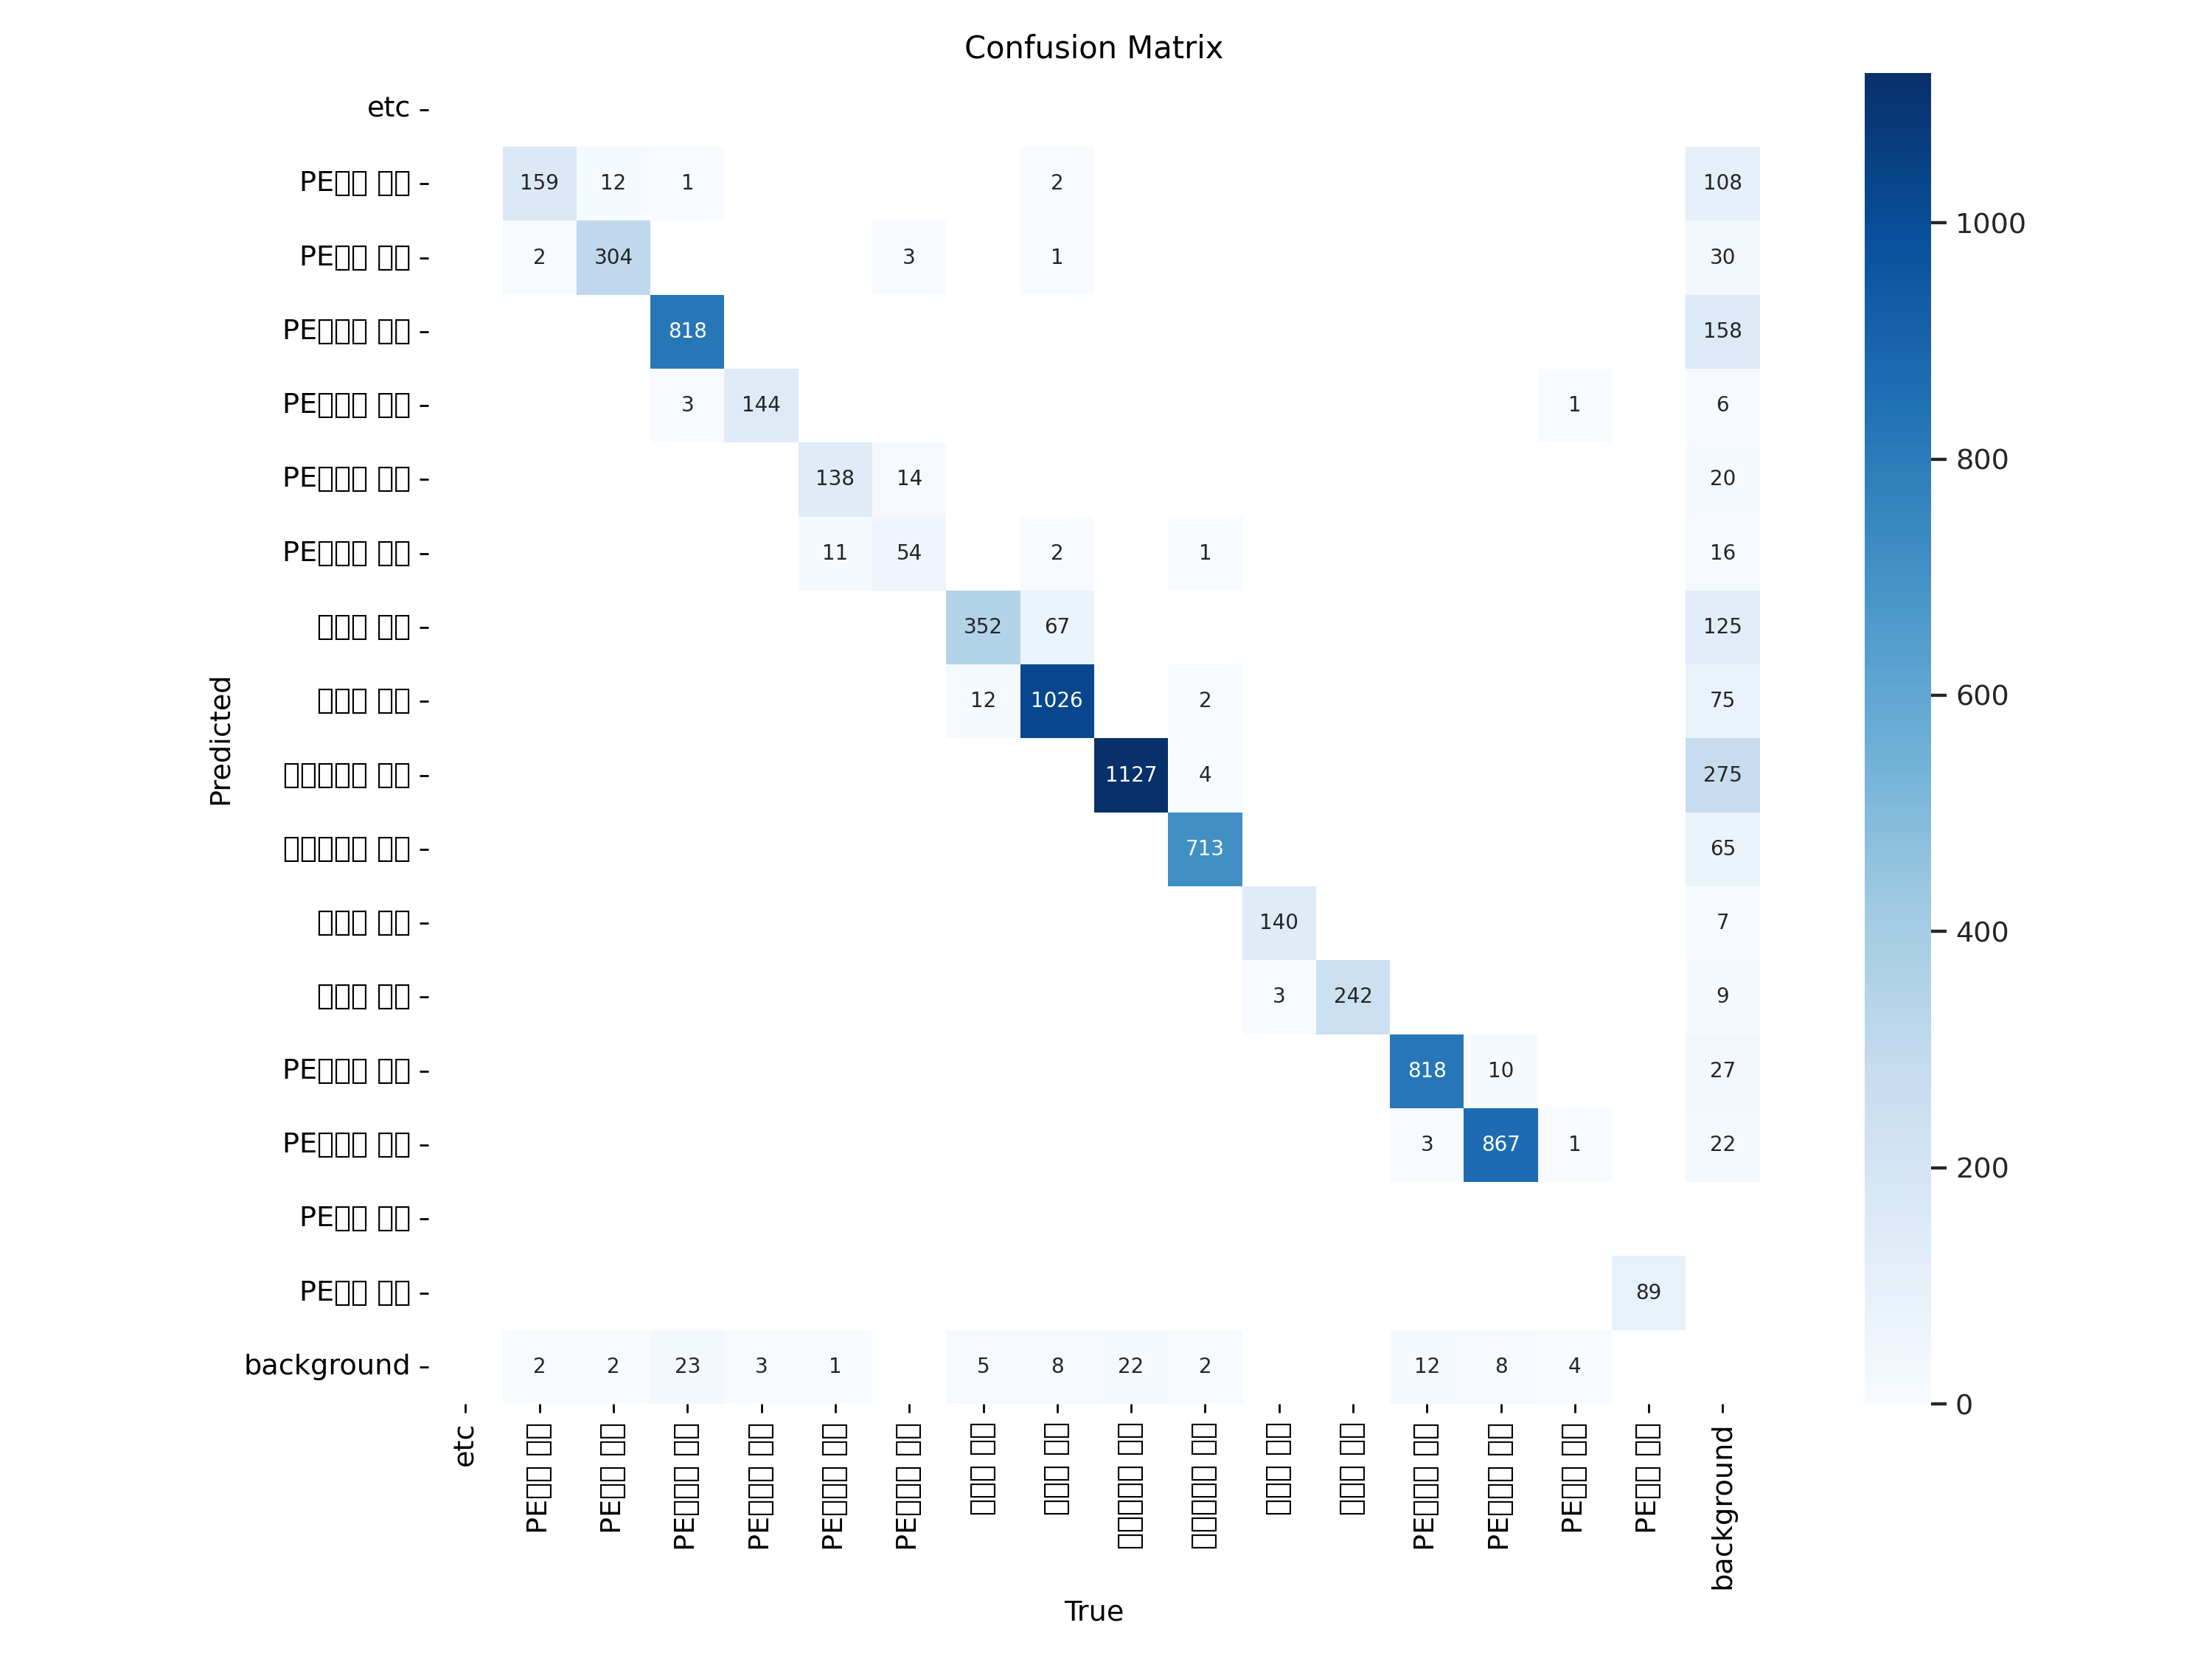

In [ ]:
# confusion matrix (all the values in here)
Image(filename=f'/content/drive/MyDrive/FinalProject/runs/detect/val/confusion_matrix.png', width=600)

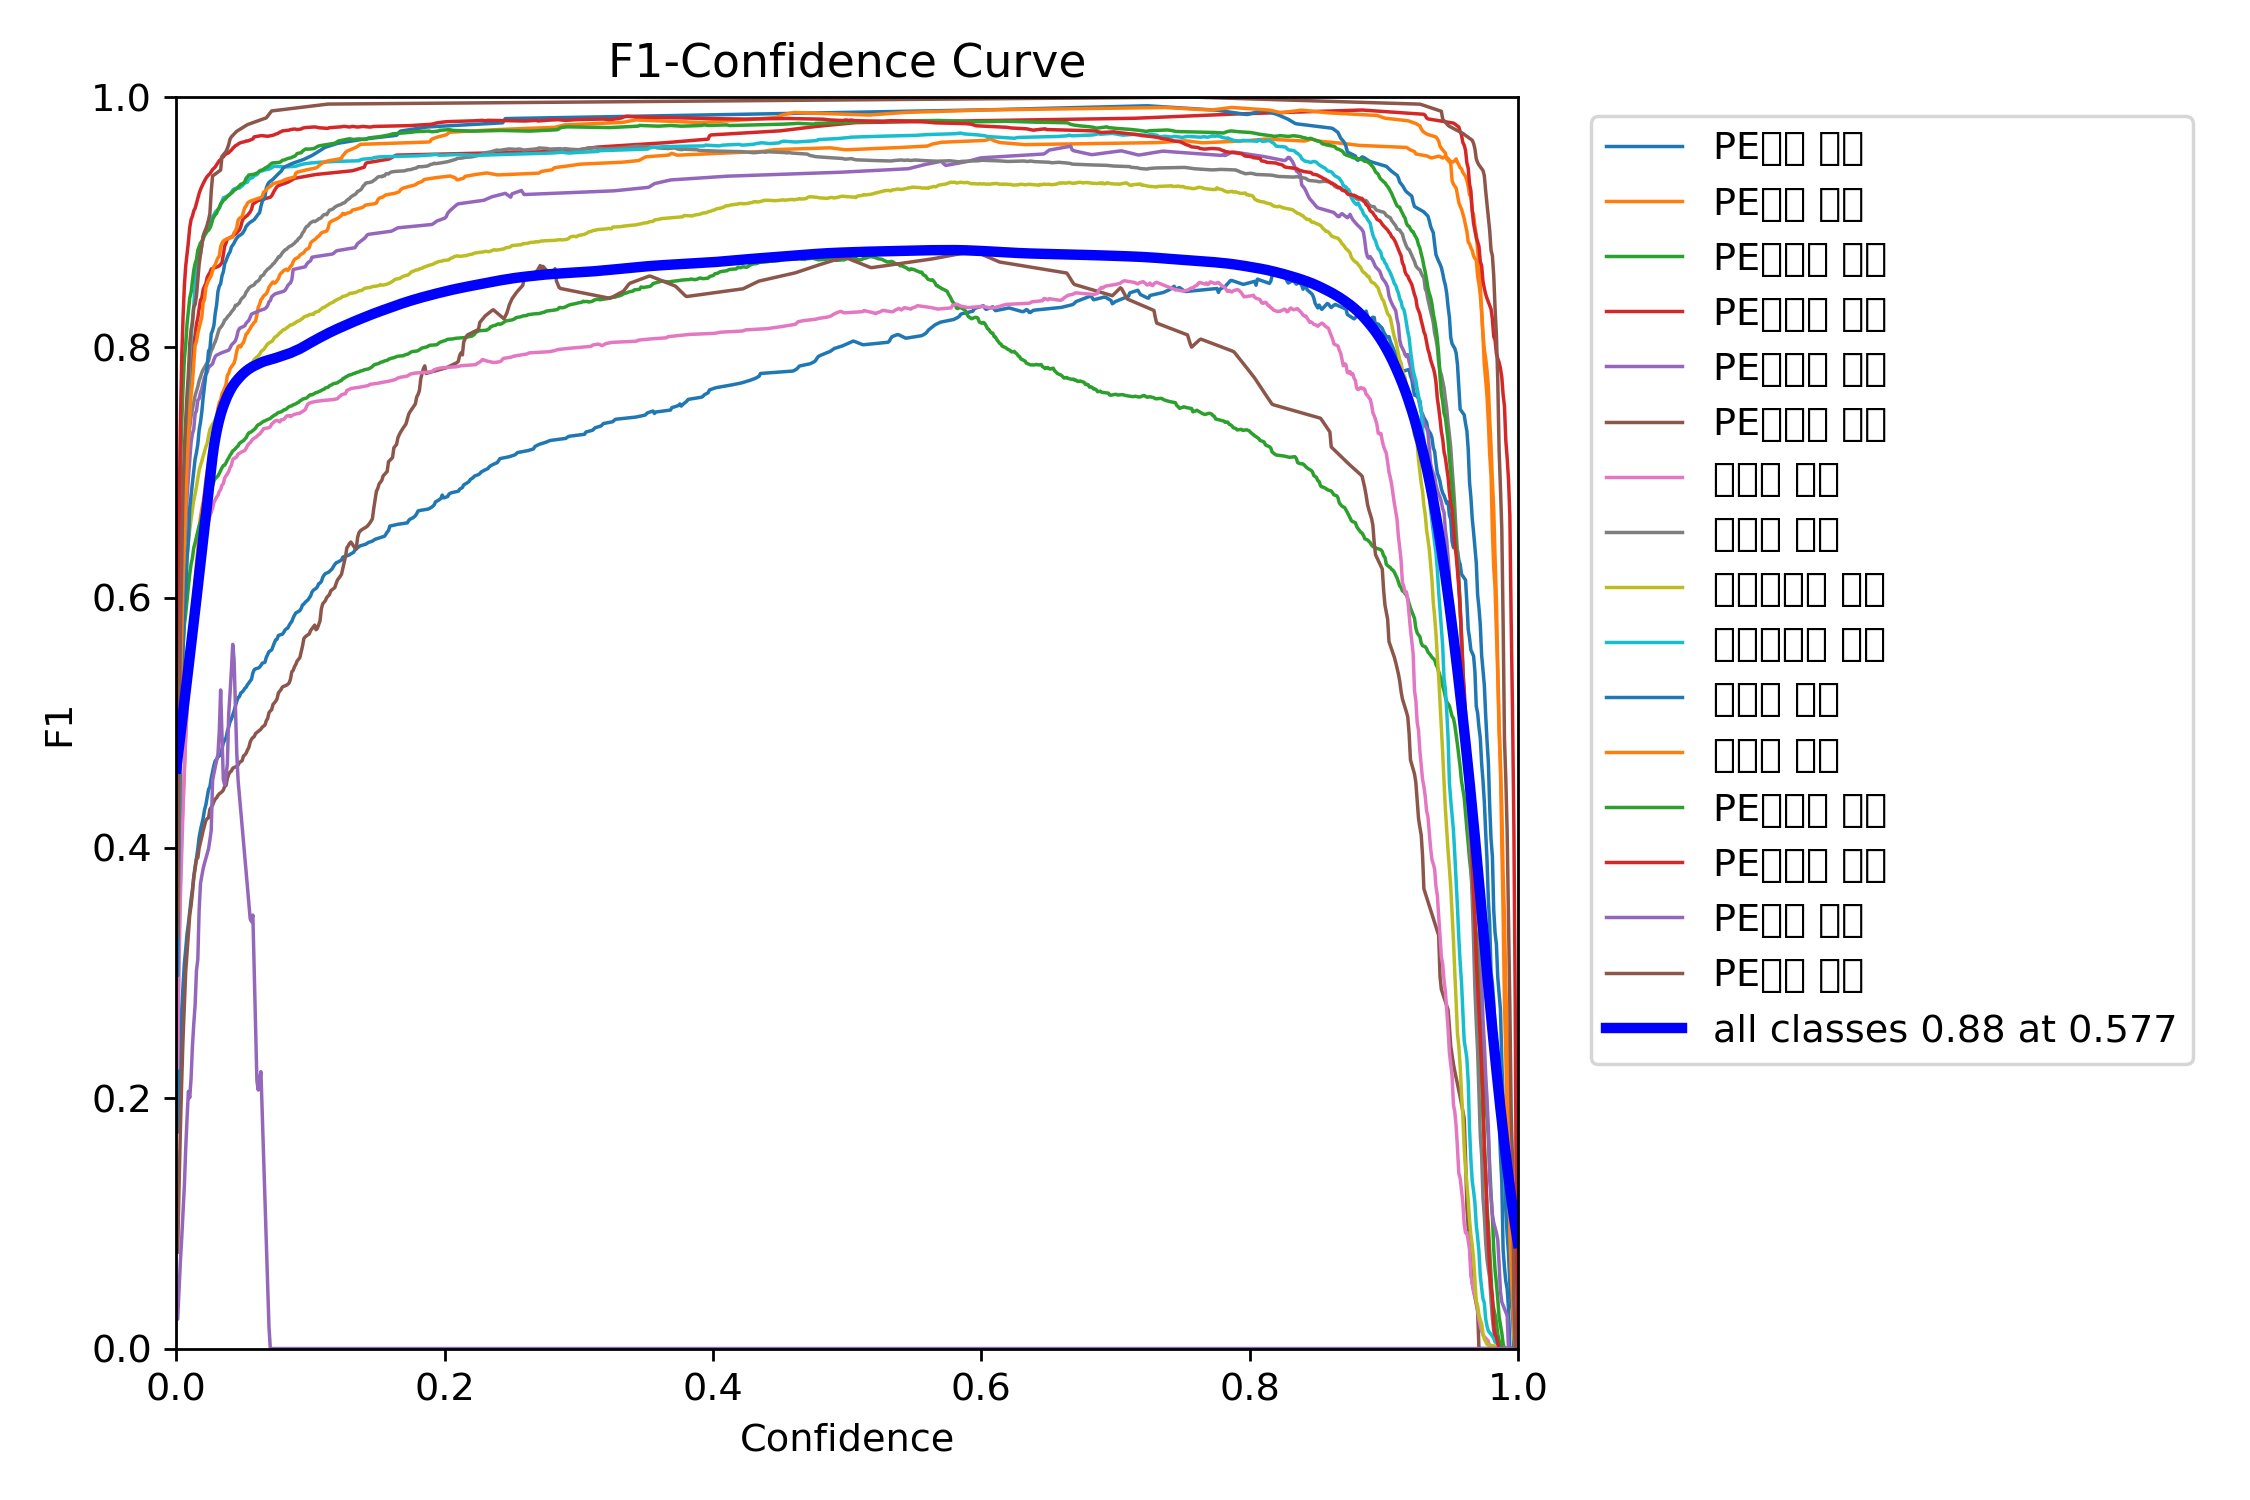

In [ ]:
# all the graph from train results
## tutorial엔 있는데 학습 후 폴더에서 찾을 수 없음
Image(filename=f'/content/drive/MyDrive/FinalProject/runs/detect/val/F1_curve.png', width=600)

In [ ]:
# prediction mode
!yolo task=detect mode=predict model=/content/drive/MyDrive/FinalProject/runs/detect/train2/weights/best.pt conf=0.5 source=/content/drive/MyDrive/FinalProject/model_test_img_3.png

Ultralytics YOLOv8.1.1 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3008963 parameters, 0 gradients, 8.1 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/drive/MyDrive/FinalProject/model_test_img_3.png: 1216x1920 1 PE드럼 정상, 2 시선유도봉 정상s, 58.1ms
Speed: 15.8ms preprocess, 58.1ms inference, 740.9ms postprocess per image at shape (1, 3, 1216, 1920)
Results saved to runs/detect/predict4
💡 Learn more at https://docs.ultralytics.com/modes/predict


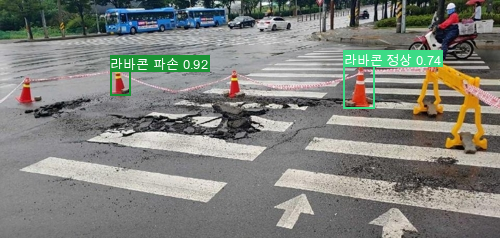

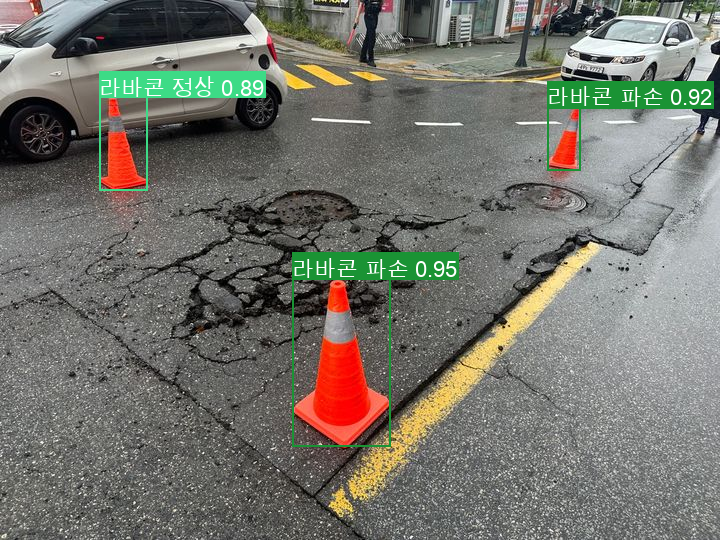

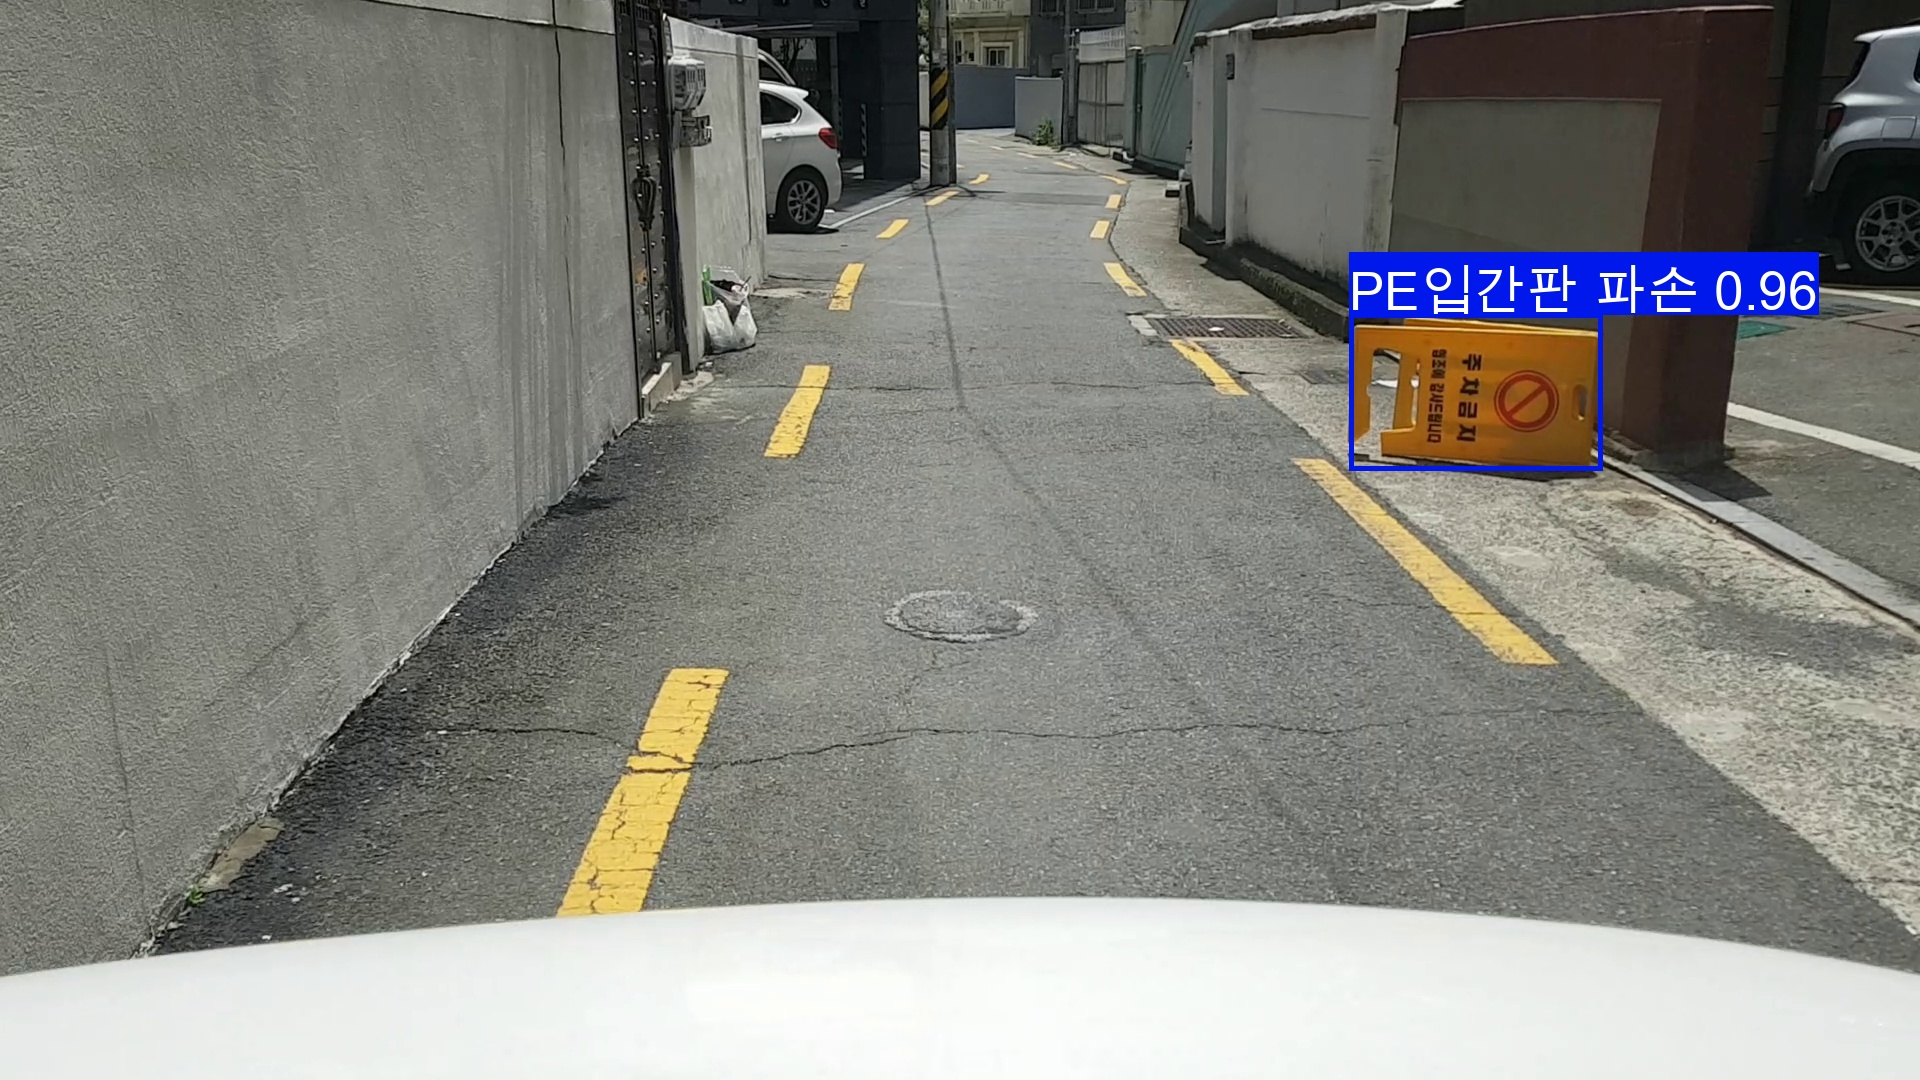

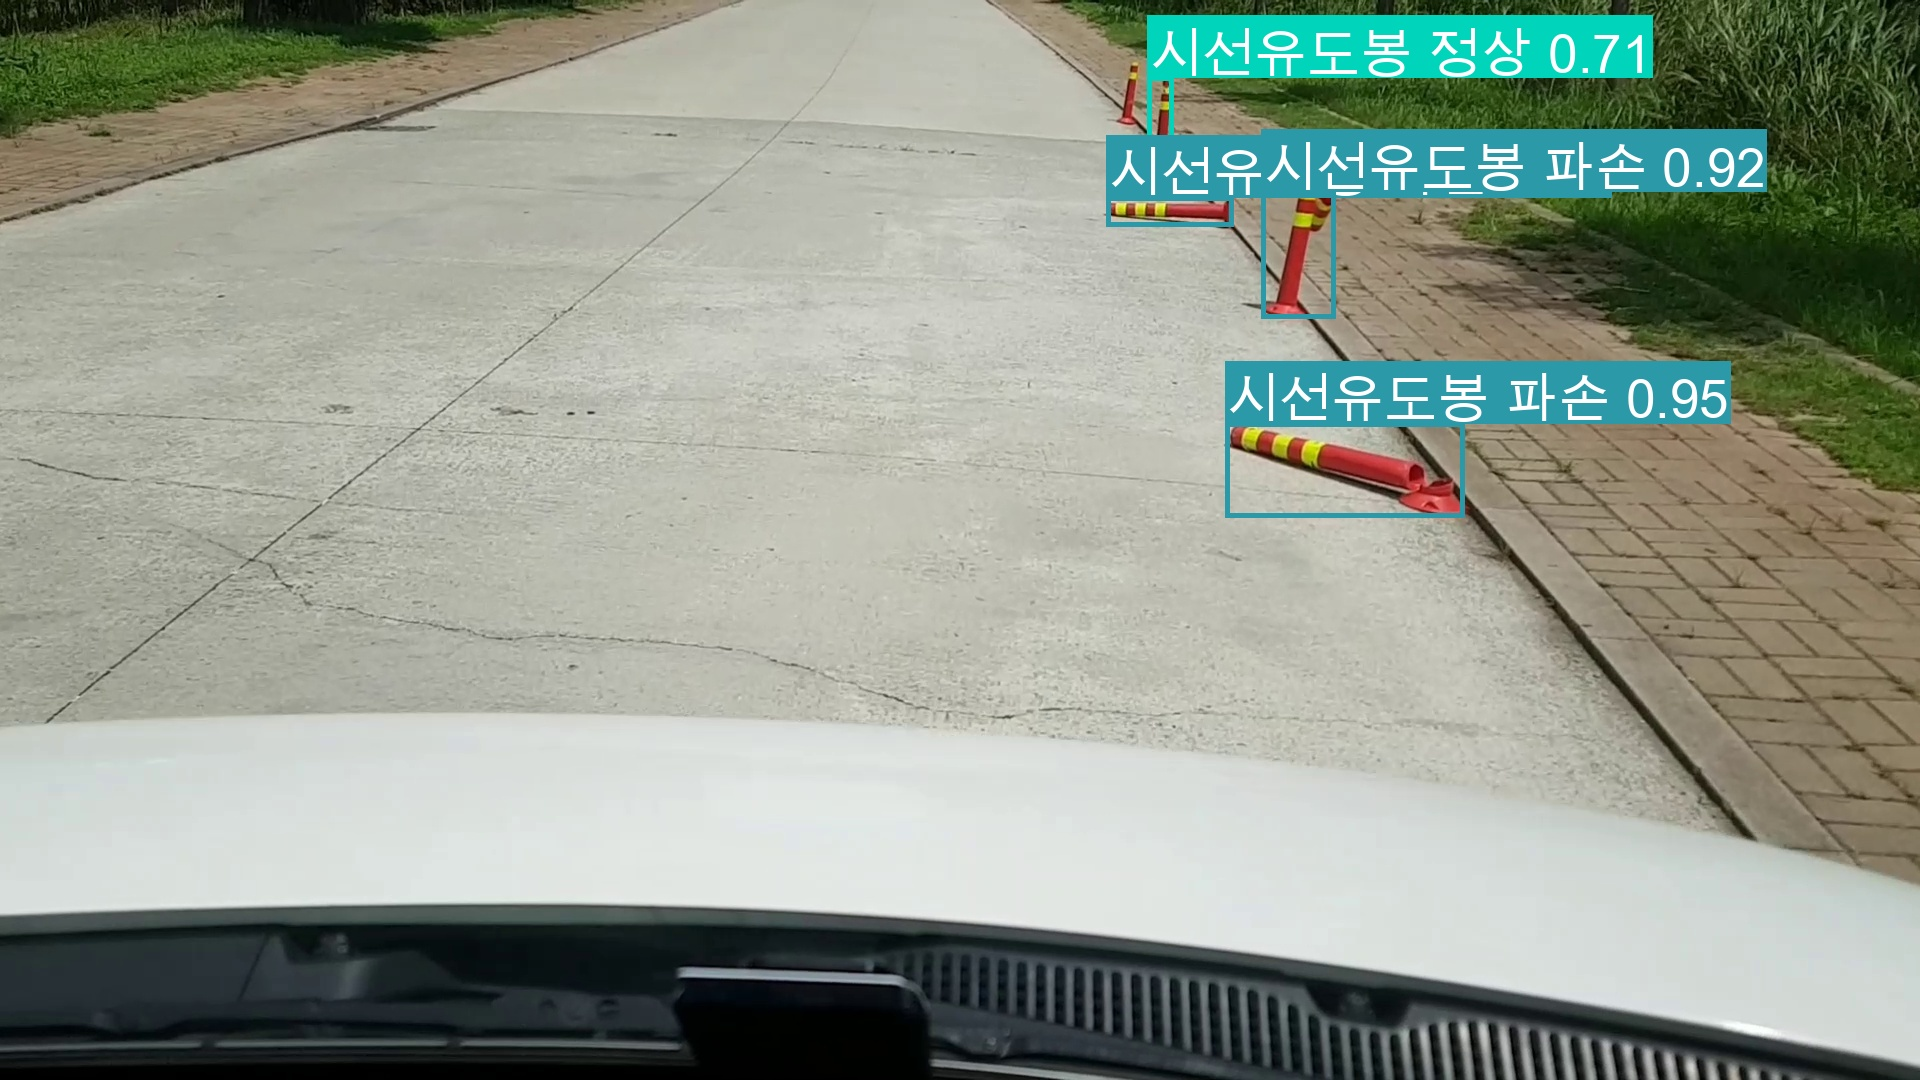

In [11]:
import glob
from IPython.display import Image, display

# detecting된 이미지를 한장씩 불러와서 확인!
for image_path in glob.glob(f'/content/drive/MyDrive/FinalProject/runs/detect/predict/*.png'):
  display(Image(filename=image_path, height=400))
  print('\n')

In [10]:
# prediction mode
!yolo task=detect mode=predict model=/content/drive/MyDrive/FinalProject/runs/detect/train2/weights/best.pt conf=0.5 source=/content/drive/MyDrive/FinalProject/test_img_8.jpg

Ultralytics YOLOv8.1.2 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3008963 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /content/drive/MyDrive/FinalProject/test_img_8.jpg: 1088x1920 2 PE입간판 파손s, 1829.1ms
Speed: 44.4ms preprocess, 1829.1ms inference, 3.3ms postprocess per image at shape (1, 3, 1088, 1920)
Results saved to runs/detect/predict6
💡 Learn more at https://docs.ultralytics.com/modes/predict


## resizing issue - resizing 필요없는 것으로 확인!

In [ ]:
from PIL import Image

def resize_images(input_dir, output_dir, new_size):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg"):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            # image resizing
            image = Image.open(input_path)
            resized_image = image.resize(new_size, Image.ANTIALIAS)
            resized_image.save(output_path)

In [ ]:
# TRAIN / image resizing (1920, 1080) -> (640, 360)
input_images_dir = '/content/drive/MyDrive/FinalProject/valid/images'
output_images_dir = '/content/drive/MyDrive/FinalProject/valid/resizing_images'
new_size = (640, 360)

resize_images(input_images_dir, output_images_dir, new_size)

image_files = [f for f in os.listdir(output_images_dir) if f.endswith('.jpg')]
print(f'Number of files in the RESIZING directory: image {len(image_files)}개')

Number of files in the RESIZING directory: image 2000개


In [ ]:
# VALID / image resizing (1920, 1080) -> (640, 360)
input_images_dir = '/content/drive/MyDrive/FinalProject/train/images'
output_images_dir = '/content/drive/MyDrive/FinalProject/train/resizing_images'
new_size = (640, 360)

resize_images(input_images_dir, output_images_dir, new_size)

image_files = [f for f in os.listdir(output_images_dir) if f.endswith('.jpg')]
print(f'Number of files in the RESIZING directory: image {len(image_files)}개')

<ipython-input-26-c5c351307ea4>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(new_size, Image.ANTIALIAS)


Number of files in the RESIZING directory: image 8000개


# Inference using custom yolov8n model

In [ ]:
import os
import cv2
import torch
import json
import math
from pathlib import Path
#from app.utils import dir_func
import numpy as np

In [ ]:
from ultralytics.nn.autobackend import AutoBackend
from ultralytics.yolo.data.dataloaders.stream_loaders import LoadImages
from ultralytics.yolo.utils.checks import check_imgsz
from ultralytics.yolo.utils.plotting import Annotator, colors
from ultralytics.yolo.utils.ops import scale_boxes, non_max_suppression
from ultralytics.yolo.engine.results import Results

In [ ]:
# 바운딩 박스가 이미지 내 어느 영역에 위치하는지를 결정
def find_location_idx(img_w, x_min, x_max):  # bbox의 최소,최대 x 좌표
    left_th = img_w // 3                     # 좌측 임계값은 이미지 폭의 1/3
    center_th = img_w * 2 // 3               # 중앙 임계값은 이미지 폭의 2/3
    x_center = (x_min + x_max) // 2
    if x_center < left_th:
        return 0
    elif x_center < center_th:
        return 1
    else:
        return 2

In [ ]:
# bbox 위치에 따라 해당 bbox와 이미지 중심 간의 거리와 헤딩(방향)을 계산
def distance_heading(img_w, img_h, x_min, x_max, y_min, y_max):    # bbox 좌표
    delta_x = (x_min + x_max) / 2 - img_w / 2                      # x 좌표 중심이 이미지의 가운데로부터 얼마나 떨어져 있는지
    delta_y = y_max - img_h                                        # bbox의 상단이 이미지의 하단으로부터 얼마나 떨어져 있는지

    distance = math.sqrt(delta_x ** 2 + delta_y ** 2)              # bbox의 중심과 이미지 중심 간의 거리를 계산(유클리드)
    heading = -math.atan2(-delta_y, delta_x) * 180 / math.pi       # bbox의 중심을 향하는 방향을 나타내는 헤딩을 계산(아크탄젠트)
    return distance, heading                                       # 계산된 거리와 헤딩을 튜플로 묶어 반환

In [ ]:
def detect(src: str, session_id: str, conf_thres=0.25, THRESHOLD_y=0.7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print('Inference with', device)

    tmp_path = os.path.join(APP_PATH, "tmp", session_id)
    img_dst = os.path.join(tmp_path, "img_dir")
    TXT_FILE = os.path.join(tmp_path, f'dist_degree.txt')
    dir_func(img_dst, rmtree=False, mkdir=True)

    model = AutoBackend(weights=os.path.join(MODEL_DIR, "yolov8", 'yolov8n_custom.pt'), device=device, dnn=False, fp16=False)
    model.eval()

    stride, names, pt = model.stride, model.names, model.pt
    imgsz = check_imgsz((640, 640), stride=stride)
    dataset = LoadImages(src, imgsz=imgsz, stride=stride, auto=pt, vid_stride=1)

    for batch in dataset:
        _, img_nparr, im0s, vid_cap, s = batch
        mask_h, mask_w, _ = im0s.shape
        mask = np.zeros(im0s.shape, np.uint8)
        mask_thres1 = np.zeros((mask_h, mask_w), np.uint8)
        mask_thres2 = np.zeros((mask_h, mask_w), np.uint8)
        break

    json_obj = {}
    # threshold line settings
    far = 0.18
    middle = 0.145
    near = 0.1

    # threshold angle settings
    angle_far = 15
    angle_middle = 30
    angle_near = 90
    angle_center = 270

    # ellipse ratio
    ellipse_value = 2.5

    # color settings
    YELLOW = (0, 255, 255)
    RED = (0, 0, 255)

    # masking value
    bitmask = 255

    # mask = np.zeros((720,1280,3),np.uint8)
    cv2.ellipse(mask, (int(mask_w / 2), mask_h), (int(mask_h * far * ellipse_value), int(mask_h * far)), 0, angle_center - angle_near, angle_center + angle_near, YELLOW, -1)
    cv2.ellipse(mask, (int(mask_w / 2), mask_h), (int(mask_h * near * ellipse_value), int(mask_h * near)), 0, angle_center - angle_near, angle_center + angle_near, RED, -1)
    cv2.ellipse(mask, (int(mask_w / 2), mask_h), (int(mask_h * middle * ellipse_value), int(mask_h * middle)), 0, angle_center - angle_middle, angle_center + angle_middle, RED, -1)
    cv2.ellipse(mask, (int(mask_w / 2), mask_h), (int(mask_h * far * ellipse_value), int(mask_h * far)), 0, angle_center - angle_far, angle_center + angle_far, RED, -1)

    # mask_thres1
    cv2.ellipse(mask_thres1, (int(mask_w / 2), mask_h), (int(mask_h * far * ellipse_value), int(mask_h * far)), 0, angle_center - angle_near, angle_center + angle_near, bitmask, -1)
    # mask_thres2
    cv2.ellipse(mask_thres2, (int(mask_w / 2), mask_h), (int(mask_h * near * ellipse_value), int(mask_h * near)), 0, angle_center - angle_near, angle_center + angle_near, bitmask, -1)
    cv2.ellipse(mask_thres2, (int(mask_w / 2), mask_h), (int(mask_h * middle * ellipse_value), int(mask_h * middle)), 0, angle_center - angle_middle, angle_center + angle_middle, bitmask, -1)
    cv2.ellipse(mask_thres2, (int(mask_w / 2), mask_h), (int(mask_h * far * ellipse_value), int(mask_h * far)), 0, angle_center - angle_far, angle_center + angle_far, bitmask, -1)

    import time
    t1 = time.time()

    for frame_idx, batch in enumerate(dataset, 1):
        _, img_nparr, im0s, vid_cap, s = batch
        annotator = Annotator(im0s, line_width=2, example=str(names))  # disable when time measurement
        img_nparr = torch.from_numpy(img_nparr)

        img_nparr = img_nparr.float()
        img_nparr /= 255.0
        if len(img_nparr.shape) == 3:
            img_nparr = img_nparr[None]

        img_nparr = img_nparr.to(device)
        bboxes_data = non_max_suppression(model(img_nparr), conf_thres=conf_thres, iou_thres=0.45, classes=None, agnostic=False, max_det=1000)

        for i, bbox in enumerate(bboxes_data):
            shape = im0s[i].shape if isinstance(im0s, list) else im0s.shape
            img_h, img_w, _ = shape
            bbox[:, :4] = scale_boxes(img_nparr.shape[2:], bbox[:, :4], (img_h, img_w)).round()

            json_obj[f'{frame_idx:04d}'] = {}
            # warn_obj=[]
            with open(TXT_FILE, 'a') as f:
                f.write(f'{frame_idx:04d}:\n')
                for obj_id, obj in enumerate(reversed(Results(boxes=bbox, orig_shape=(img_h, img_w)).boxes), 1):
                    bbox = obj.xyxy.squeeze()
                    x_min, y_min, x_max, y_max = bbox_list = bbox.tolist()

                    dist, angle = distance_heading(img_w, img_h, *bbox_list)

                    f.write(f'{obj_id:02d} {dist:.1f} {angle:.1f} {bbox}\n')

                    warn = 3
                    np_size = (int(y_max - y_min), int(x_max - x_min))

                    if np.any((mask_thres1[int(y_min):int(y_max), int(x_min):int(x_max)] & np.ones(np_size, np.uint8)) > 0):
                        warn = 2
                        if np.any((mask_thres2[int(y_min):int(y_max), int(x_min):int(x_max)] & np.ones(np_size, np.uint8)) > 0):
                            warn = 1
                    cls = obj.cls.squeeze()
                    c = int(cls)
                    label = f'{model.names[c]}'
                    annotator.box_label(bbox, label, color=colors(4 * (warn - 1), True))  # disable when time measurement

                    json_obj[f'{frame_idx:04d}'][f'{obj_id:02d}'] = {"class": f'{model.names[c]}',
                                                                     "warning_lv": f"{warn}",
                                                                     "location": f'{find_location_idx(img_w, x_min, x_max)}',
                                                                     "distance": round(dist, 2),
                                                                     "heading": round(angle, 1)}

        cv2.imwrite(os.path.join(img_dst, f"{frame_idx:04}.jpg"), cv2.addWeighted(mask, 0.2, annotator.result(), 0.8, 0))  # disable when time measurement
        # cv2.imwrite(os.path.join(img_dst, f"{frame_idx:04}.jpg"), im0s)  # enable when time measurement

    elapsedtime = time.time() - t1
    print(f'Inference time {elapsedtime}/Frames {frame_idx}')  # time measurement

    return json.dumps(json_obj, ensure_ascii=False, indent=None, sort_keys=True)